# Covid-19 Daily Deaths - UK

Via: https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/

At the moment, each time this script runs it downloads all the daily datafiles and builds the db from scratch. We need to optimise things so that only new daily files are parsed and added, incrementally, to the database.

Daily reports are published as an Excel spreadhseet linked from the following page:

In [4]:
# Reporting page
url = 'https://www.england.nhs.uk/statistics/statistical-work-areas/covid-19-daily-deaths/'

Load the page:

In [5]:
import requests

page = requests.get(url)

Get the HTML page data into a form we can scrape it:

In [6]:
from bs4 import BeautifulSoup, SoupStrainer

soup = BeautifulSoup(page.text)

Get the relevant links to the daily spreadseets:

In [7]:
links = {}
for link in soup.find("article", {"class": "rich-text"}).find_all('a'):
    if link.text.startswith('COVID 19 daily announced deaths'):
        if link.text not in links:
            links[link.text] = link.get('href')
    elif link.text.startswith('COVID 19 total announced deaths'):
            totals_link =  link.get('href')
links

{'COVID 19 daily announced deaths 9 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced-deaths-9-May-2020.xlsx',
 'COVID 19 daily announced deaths 8 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced-deaths-8-May-2020.xlsx',
 'COVID 19 daily announced deaths 7 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced-deaths-7-May-2020.xlsx',
 'COVID 19 daily announced deaths 6 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced-deaths-6-May-2020.xlsx',
 'COVID 19 daily announced deaths 5 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced-deaths-5-May-2020.xlsx',
 'COVID 19 daily announced deaths 4 May 2020': 'https://www.england.nhs.uk/statistics/wp-content/uploads/sites/2/2020/05/COVID-19-daily-announced

In [8]:
import numpy as np
import pandas as pd

Start to sketch out how we can parse the data out of one of the spreadsheets. The following has been arrivied though a little bit of iteration an previewing of the data:

In [9]:
sheets = pd.read_excel(links['COVID 19 daily announced deaths 9 April 2020'],
                           sheet_name=None)

# What sheets are available in the spreadsheet
sheet_names = sheets.keys()
sheet_names

odict_keys(['COVID19 daily deaths by region', 'COVID19 daily deaths by age', 'COVID19 daily deaths by trust'])

The spreadsheet contains the following sheets:

- `COVID19 daily deaths by region`
- `COVID19 daily deaths by age`
- `COVID19 daily deaths by trust`


## Cleaning the Sheets

Clean the sheets to get the actual data:

In [10]:
sheet = 'COVID19 daily deaths by region'
sheets[sheet].head(15)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 32,Unnamed: 33,Unnamed: 34,Unnamed: 35,Unnamed: 36,Unnamed: 37,Unnamed: 38,Unnamed: 39,Unnamed: 40,Unnamed: 41
0,NaN,Title:,COVID-19 daily deaths announcement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,Summary:,Deaths of patients who have died in hospitals ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Period:,5pm 07 April 2020 - 5pm 08 April 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Source:,COVID-19 Patient Notification System,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Basis:,Provider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Published:,2020-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Revised:,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Status:,Published,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Contact:,england.nhsdata@nhs.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We don't necessarily know how much metadata there is at the start of the sheet so we need to emply heuristics. If *NHS England Region* is used consistently as a column heading, we can use that as a crib:

In [11]:
rows, cols = np.where(sheets[sheet] == 'NHS England Region')
rows, cols

/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


(array([12]), array([1]))

In [12]:
colnames = sheets[sheet].iloc[12]
sheets[sheet] = sheets[sheet].iloc[15:]
sheets[sheet].columns = colnames
sheets[sheet].dropna(axis=1, how='all', inplace=True)
sheets[sheet].dropna(axis=0, how='all', inplace=True)
#sheets[sheet].dropna(axis=0, subset=[sheets[sheet].columns[0]], inplace=True)
sheets[sheet].head()

12,NHS England Region,2020-03-16 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,...,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,Awaiting verification,Total
15,East Of England,0,0,0,0,0,0,0,0,0,...,1,7,2,8,15,15,42,20,0,113
16,London,1,2,0,2,1,2,2,6,5,...,7,10,15,16,12,25,61,29,0,213
17,Midlands,0,0,0,0,0,0,0,0,1,...,8,3,5,7,13,22,41,17,0,124
18,North East And Yorkshire,0,0,0,0,0,0,0,0,0,...,0,2,0,0,4,6,48,32,0,92
19,North West,0,0,0,0,0,0,0,0,0,...,2,4,6,4,2,6,35,18,0,77


The ages data is structured differently, but we can perhaps use *Age Group* as a crib?

In [13]:
sheet = 'COVID19 daily deaths by age'
sheets[sheet].head(25)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 17,Unnamed: 18,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,NaN,Title:,COVID-19 daily deaths announcement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AE_Closures,NaN,NaN,NaN,NaN,NaN
1,NaN,Summary:,Deaths of patients who have died in hospitals ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Period:,5pm 07 April 2020 - 5pm 08 April 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Source:,COVID-19 Patient Notification System,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Basis:,Provider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Published:,2020-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Revised:,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Status:,Published,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,Contact:,england.nhsdata@nhs.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


We can extract the published date to provide an additional metadata column:

In [14]:
rows, cols = np.where(sheets[sheet] == 'Published:')
published_date = sheets[sheet].iat[rows[0], cols[0]+1]
published_date

Timestamp('2020-04-09 00:00:00')

Try the crib:

In [15]:
rows, cols = np.where(sheets[sheet] == 'Age group')
rows, cols

(array([13]), array([1]))

Does the same cleaning pattern work?

In [16]:
colnames = sheets[sheet].iloc[13]
sheets[sheet] = sheets[sheet].iloc[16:]
sheets[sheet].columns = colnames
sheets[sheet].dropna(axis=0, how='all', inplace=True)
sheets[sheet].dropna(axis=1, how='all', inplace=True)
#sheets[sheet].dropna(axis=0, subset=[sheets[sheet].columns[0]], inplace=True)
sheets[sheet].head()

13,Age group,2020-03-16 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-26 00:00:00,2020-03-27 00:00:00,2020-03-28 00:00:00,...,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,Awaiting verification,Total
16,0-19,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
17,20-39,0,0,0,0,0,0,0,0,0,...,2,0,0,0,0,0,4,0,0,6
18,40-59,0,0,0,0,0,0,0,1,1,...,0,2,0,5,3,5,16,18,0,54
19,60-79,1,2,1,0,0,1,0,1,3,...,7,15,17,19,21,38,112,42,0,290
20,80+,0,0,0,2,1,1,3,4,3,...,10,13,14,23,33,57,152,80,0,415


Again, *NHS England Region* may be a handy crib in the following sheet:

In [17]:
sheet = 'COVID19 daily deaths by trust'
sheets[sheet].head(15)

,Unnamed: 0,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 19,Unnamed: 20,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26,Unnamed: 27,Unnamed: 28
0,NaN,Title:,COVID-19 daily deaths announcement,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,AE_Closures,NaN,NaN,NaN,NaN,NaN
1,NaN,Summary:,Deaths of patients who have died in hospitals ...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,Period:,5pm 07 April 2020 - 5pm 08 April 2020,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,Source:,COVID-19 Patient Notification System,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,NaN,Basis:,Provider,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,Published:,2020-04-09 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,Revised:,-,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,Status:,Published,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,NaN,Contact:,england.nhsdata@nhs.net,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


The same cleaning pattern we used before seems to work fine:

In [18]:
colnames = sheets[sheet].iloc[12]
sheets[sheet] = sheets[sheet].iloc[15:]
sheets[sheet].columns = colnames
sheets[sheet].dropna(axis=1, how='all', inplace=True)
sheets[sheet].dropna(axis=0, how='all', inplace=True)
#sheets[sheet].dropna(axis=0, subset=[sheets[sheet].columns[0]], inplace=True)
sheets[sheet].head()

12,NHS England Region,Code,Name,2020-03-16 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-26 00:00:00,...,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,Awaiting verification,Total
15,East Of England,NQ1,ANGLIAN COMMUNITY ENTERPRISE CIC - CLACTON HOS...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
16,East Of England,NQ1,ANGLIAN COMMUNITY ENTERPRISE CIC - FRYATT HOSP...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1
17,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,0,0,0,0,0,0,0,...,0,2,0,2,3,7,5,3,0,24
18,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,0,0,0,0,0,0,0,...,0,0,0,0,0,1,1,0,0,2
19,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,1


The following tries to clean things automatically - we drop the national aggregate values:

In [43]:
# Should work for:
#COVID19 total deaths by trust
#COVID19 total deaths by region
#COVID19 total deaths by age
#COVID19 all deaths by ethnicity
#COVID19 all deaths by gender

# Currently excludes:
#COVID19 total deaths chart
#Deaths by region - no pos test
#COVID19 all deaths by condition

def cleaner(sheets):
    for sheet in sheets:
        print(sheet)
        if 'chart' in sheet or 'no pos' in sheet or 'condition' in sheet:
            continue
        rows, cols = np.where(sheets[sheet] == 'Published:')
        published_date = sheets[sheet].iat[rows[0], cols[0]+1]

        if 'age' in sheet or 'gender' in sheet:
            rows, cols = np.where(sheets[sheet] == 'Age group')
            #print((rows, cols))
            _ix= rows[0]
        elif 'ethnicity' in sheet:
            rows, cols = np.where(sheets[sheet] == 'Ethnic group')
            #print((rows, cols))
            _ix= rows[0]
        else:
            rows, cols = np.where(sheets[sheet] == 'NHS England Region')
            #print((sheet, rows, cols))
            _ix= rows[0] #ix[sheet][0]

        colnames = sheets[sheet].iloc[_ix]
        sheets[sheet] = sheets[sheet].iloc[_ix+3:]
        sheets[sheet].columns = colnames
        sheets[sheet].dropna(axis=1, how='all', inplace=True)
        sheets[sheet].dropna(axis=0, how='all', inplace=True)
        sheets[sheet] = sheets[sheet].loc[:, sheets[sheet].columns.notnull()]
        #display(f'Checking: {sheet}')
        sheets[sheet]['Published'] = published_date
        #sheets[sheet].dropna(axis=0, subset=[sheets[sheet].columns[0]], inplace=True)
    return sheets

Grab all the daily reports:

In [20]:
data = {}

for link in links:
    print(link)
    sheets = pd.read_excel(links[link], sheet_name=None)
    sheets = cleaner(sheets)
    data[link] = sheets



COVID 19 daily announced deaths 9 May 2020
COVID 19 daily announced deaths 8 May 2020
COVID 19 daily announced deaths 7 May 2020
COVID 19 daily announced deaths 6 May 2020
COVID 19 daily announced deaths 5 May 2020
COVID 19 daily announced deaths 4 May 2020
COVID 19 daily announced deaths 3 May 2020
COVID 19 daily announced deaths 2 May 2020
COVID 19 daily announced deaths 1 May 2020
COVID 19 daily announced deaths 30 April 2020
COVID 19 daily announced deaths 29 April 2020
COVID 19 daily announced deaths 28 April 2020
COVID 19 daily announced deaths 27 April 2020
COVID 19 daily announced deaths 26 April 2020
COVID 19 daily announced deaths 25 April 2020
COVID 19 daily announced deaths 24 April 2020
COVID 19 daily announced deaths 23 April 2020
COVID 19 daily announced deaths 22 April 2020
COVID 19 daily announced deaths 21 April 2020
COVID 19 daily announced deaths 20 April 2020
COVID 19 daily announced deaths 19 April 2020
COVID 19 daily announced deaths 18 April 2020
COVID 19 daily 

In [21]:
data.keys()

dict_keys(['COVID 19 daily announced deaths 9 May 2020', 'COVID 19 daily announced deaths 8 May 2020', 'COVID 19 daily announced deaths 7 May 2020', 'COVID 19 daily announced deaths 6 May 2020', 'COVID 19 daily announced deaths 5 May 2020', 'COVID 19 daily announced deaths 4 May 2020', 'COVID 19 daily announced deaths 3 May 2020', 'COVID 19 daily announced deaths 2 May 2020', 'COVID 19 daily announced deaths 1 May 2020', 'COVID 19 daily announced deaths 30 April 2020', 'COVID 19 daily announced deaths 29 April 2020', 'COVID 19 daily announced deaths 28 April 2020', 'COVID 19 daily announced deaths 27 April 2020', 'COVID 19 daily announced deaths 26 April 2020', 'COVID 19 daily announced deaths 25 April 2020', 'COVID 19 daily announced deaths 24 April 2020', 'COVID 19 daily announced deaths 23 April 2020', 'COVID 19 daily announced deaths 22 April 2020', 'COVID 19 daily announced deaths 21 April 2020', 'COVID 19 daily announced deaths 20 April 2020', 'COVID 19 daily announced deaths 19 

Just as an aside, we can informally extract the publication date of a spreadheet from the associated link text on the original web page (trusting that the link does refer to the correctly linked document):

In [22]:
from parse import parse
import dateparser

def getLinkDate(link):
    """Get date from link text."""
    _date = parse('COVID 19 daily announced deaths {date}', link)['date']
    return dateparser.parse(_date)

In [23]:
#Test the date extractor
getLinkDate('COVID 19 daily announced deaths 15 April 2020')

datetime.datetime(2020, 4, 15, 0, 0)

In [24]:
data['COVID 19 daily announced deaths 9 April 2020'].keys()

odict_keys(['COVID19 daily deaths by region', 'COVID19 daily deaths by age', 'COVID19 daily deaths by trust'])

Preview what sort of data we've got:

In [25]:
df = data['COVID 19 daily announced deaths 9 April 2020']['COVID19 daily deaths by trust']
df

12,NHS England Region,Code,Name,2020-03-16 00:00:00,2020-03-19 00:00:00,2020-03-20 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,2020-03-24 00:00:00,2020-03-26 00:00:00,...,2020-04-02 00:00:00,2020-04-03 00:00:00,2020-04-04 00:00:00,2020-04-05 00:00:00,2020-04-06 00:00:00,2020-04-07 00:00:00,2020-04-08 00:00:00,Awaiting verification,Total,Published
15,East Of England,NQ1,ANGLIAN COMMUNITY ENTERPRISE CIC - CLACTON HOS...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2020-04-09
16,East Of England,NQ1,ANGLIAN COMMUNITY ENTERPRISE CIC - FRYATT HOSP...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2020-04-09
17,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,0,0,0,0,0,0,0,...,2,0,2,3,7,5,3,0,24,2020-04-09
18,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,0,0,0,0,0,0,0,...,0,0,0,0,1,1,0,0,2,2020-04-09
19,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2020-04-09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
181,South West,RA9,TORBAY AND SOUTH DEVON NHS FOUNDATION TRUST,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-04-09
182,South West,RA7,UNIVERSITY HOSPITALS BRISTOL NHS FOUNDATION TRUST,0,0,0,0,0,0,0,...,0,0,0,0,1,2,1,0,4,2020-04-09
183,South West,RK9,UNIVERSITY HOSPITALS PLYMOUTH NHS TRUST,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,1,2020-04-09
184,South West,RA3,WESTON AREA HEALTH NHS TRUST,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2020-04-09


Preview a specific area, albeit with quite an informal search term:

In [26]:
df = data['COVID 19 daily announced deaths 4 April 2020']['COVID19 daily deaths by trust']
df[df['Name'].str.contains('WIGHT')]

12,NHS England Region,Code,Name,2020-03-03 00:00:00,2020-03-16 00:00:00,2020-03-18 00:00:00,2020-03-20 00:00:00,2020-03-21 00:00:00,2020-03-22 00:00:00,2020-03-23 00:00:00,...,2020-03-28 00:00:00,2020-03-29 00:00:00,2020-03-30 00:00:00,2020-03-31 00:00:00,2020-04-01 00:00:00,2020-04-02 00:00:00,2020-04-03 00:00:00,Awaiting verification,Total,Published
132,South East,R1F,ISLE OF WIGHT NHS TRUST,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,1,2020-04-04


Grab the totals:

In [44]:
totals_xl = pd.read_excel(totals_link, sheet_name=None)
totals_xl.keys()

odict_keys(['COVID19 total deaths chart', 'COVID19 total deaths by trust', 'COVID19 total deaths by region', 'Deaths by region - no pos test', 'COVID19 total deaths by age', 'COVID19 all deaths by ethnicity', 'COVID19 all deaths by gender', 'COVID19 all deaths by condition'])

In [45]:
totals_xl = cleaner(totals_xl)
totals_xl.keys()

COVID19 total deaths chart
COVID19 total deaths by trust


'Checking: COVID19 total deaths by trust'

COVID19 total deaths by region


'Checking: COVID19 total deaths by region'

Deaths by region - no pos test
COVID19 total deaths by age


'Checking: COVID19 total deaths by age'

COVID19 all deaths by ethnicity


'Checking: COVID19 all deaths by ethnicity'

COVID19 all deaths by gender


'Checking: COVID19 all deaths by gender'

COVID19 all deaths by condition


odict_keys(['COVID19 total deaths chart', 'COVID19 total deaths by trust', 'COVID19 total deaths by region', 'Deaths by region - no pos test', 'COVID19 total deaths by age', 'COVID19 all deaths by ethnicity', 'COVID19 all deaths by gender', 'COVID19 all deaths by condition'])

In [46]:
dfs = totals_xl['COVID19 total deaths by trust']
dfs[dfs['Name'].str.contains('WIGHT')]

14,NHS England Region,Code,Name,Up to 01-Mar-20,2020-03-01 00:00:00,2020-03-02 00:00:00,2020-03-03 00:00:00,2020-03-04 00:00:00,2020-03-05 00:00:00,2020-03-06 00:00:00,...,2020-05-02 00:00:00,2020-05-03 00:00:00,2020-05-04 00:00:00,2020-05-05 00:00:00,2020-05-06 00:00:00,2020-05-07 00:00:00,2020-05-08 00:00:00,Awaiting verification,Total,Published
185,South East,R1F,ISLE OF WIGHT NHS TRUST,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,29,09 May 2020


## Adding NHS Daily Data to a Database

The data is perhaps most easily managed in a long form. We could normalise the data properly across several tables, or for mow we can just grab perhaps slightly denormalised tables for the dates and separate tables for totals and result awaiting verification:

In [47]:
df_dailies = df.drop(columns=['Awaiting verification', 'Total'])
tmp = df_dailies.melt(id_vars=['NHS England Region','Code','Name', 'Published'],
                      var_name='Date',
                      value_name='value')
tmp.head()

,NHS England Region,Code,Name,Published,Date,value
0,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,2020-04-04,2020-03-03,0
1,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,2020-04-04,2020-03-03,0
2,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,2020-04-04,2020-03-03,0
3,East Of England,RWH,EAST AND NORTH HERTFORDSHIRE NHS TRUST,2020-04-04,2020-03-03,0
4,East Of England,RDE,EAST SUFFOLK AND NORTH ESSEX NHS FOUNDATION TRUST,2020-04-04,2020-03-03,0


Find the days lag between published and strike date:

In [48]:
tmp['Date'] = pd.to_datetime(tmp['Date'])
tmp['lag'] = tmp['Published'] - tmp['Date']
tmp.head()

,NHS England Region,Code,Name,Published,Date,value,lag
0,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,2020-04-04,2020-03-03,0,32 days
1,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,2020-04-04,2020-03-03,0,32 days
2,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,2020-04-04,2020-03-03,0,32 days
3,East Of England,RWH,EAST AND NORTH HERTFORDSHIRE NHS TRUST,2020-04-04,2020-03-03,0,32 days
4,East Of England,RDE,EAST SUFFOLK AND NORTH ESSEX NHS FOUNDATION TRUST,2020-04-04,2020-03-03,0,32 days


Create a simple SQLite database:

In [49]:
import sqlite_utils
!rm nhs_dailies.db
DB = sqlite_utils.Database("nhs_dailies.db")

Add the daily data to the db:

In [52]:
df_long.head()

,NHS England Region,Published,Date,value
0,East Of England,09 May 2020,2020-03-12,0
1,London,09 May 2020,2020-03-12,1
2,Midlands,09 May 2020,2020-03-12,0
3,North East And Yorkshire,09 May 2020,2020-03-12,0
4,North West,09 May 2020,2020-03-12,0


In [66]:
idx = {'trust': ['NHS England Region','Code','Name', 'Published'],
       'age': ['Age group', 'Published'],
       'region': ['NHS England Region', 'Published'] }

# TO DO  - ethnicity
for daily in data.keys():
    #print(daily)
    #linkDate = getLinkDate(daily)
    # TO DO - get data from excluded sheets
    for sheet in data[daily].keys():
        if 'chart' in sheet or 'condition' in sheet or 'test' in sheet:
            continue
        #print(sheet)
        table = parse('COVID19 daily deaths by {table}', sheet)['table']
        df_dailies = data[daily][sheet].drop(columns=['Awaiting verification', 'Total'])
        #df_dailies['Link_date'] = linkDate
        idx_cols = idx[table]#+['Link_date']
        df_long = df_dailies.melt(id_vars=idx_cols,
                                  var_name='Date',
                                  value_name='value')
        df_long['Date'] = pd.to_datetime(df_long['Date'])
        if df_long['Published'].dtype == 'O':
            df_long['Published'] = df_long['Published'].apply(dateparser.parse)
        df_long['lag'] = (df_long['Published'] - df_long['Date']).dt.days

        _table = f'nhs_dailies_{table}'
        df_long.to_sql(_table, DB.conn, index=False, if_exists='append')
        
        cols = idx[table] + ['Awaiting verification', 'Total']
        data[daily][sheet][cols].to_sql(f'{_table}_summary',
                                        DB.conn, index=False, if_exists='append')

Dummy query on `age` sheet:

In [67]:
pd.read_sql("SELECT * FROM nhs_dailies_age LIMIT 25", DB.conn)

,Age group,Published,Date,value,lag
0,0-19,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
1,20-39,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
2,40-59,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
3,60-79,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
4,80+,2020-05-09 00:00:00,2020-03-12 00:00:00,1,58
5,TBC,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
6,0-19,2020-05-09 00:00:00,2020-03-13 00:00:00,0,57
7,20-39,2020-05-09 00:00:00,2020-03-13 00:00:00,0,57
8,40-59,2020-05-09 00:00:00,2020-03-13 00:00:00,0,57
9,60-79,2020-05-09 00:00:00,2020-03-13 00:00:00,1,57


Dummy query on `age_summary` sheet:

In [68]:
pd.read_sql("SELECT * FROM nhs_dailies_age_summary LIMIT 5", DB.conn)

,Age group,Published,Awaiting verification,Total
0,0-19,09 May 2020,0,0
1,20-39,09 May 2020,0,1
2,40-59,09 May 2020,0,9
3,60-79,09 May 2020,0,74
4,80+,09 May 2020,0,123


Dummy query on `trust` sheet:

In [69]:
pd.read_sql("SELECT * FROM nhs_dailies_trust LIMIT 5", DB.conn)

,NHS England Region,Code,Name,Published,Date,value,lag
0,East Of England,NQ108,ANGLIAN COMMUNITY ENTERPRISE CIC - CLACTON HOS...,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
1,East Of England,NQ106,ANGLIAN COMMUNITY ENTERPRISE CIC - FRYATT HOSP...,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
2,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
3,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
4,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58


Dummy query on `trust_summary` sheet:

In [70]:
pd.read_sql("SELECT * FROM nhs_dailies_trust_summary LIMIT 5", DB.conn)

,NHS England Region,Code,Name,Published,Awaiting verification,Total
0,East Of England,NQ108,ANGLIAN COMMUNITY ENTERPRISE CIC - CLACTON HOS...,09 May 2020,0,0
1,East Of England,NQ106,ANGLIAN COMMUNITY ENTERPRISE CIC - FRYATT HOSP...,09 May 2020,0,0
2,East Of England,RDD,BASILDON AND THURROCK UNIVERSITY HOSPITALS NHS...,09 May 2020,0,2
3,East Of England,RC1,BEDFORD HOSPITAL NHS TRUST,09 May 2020,0,0
4,East Of England,RGT,CAMBRIDGE UNIVERSITY HOSPITALS NHS FOUNDATION ...,09 May 2020,0,0


Dummy query on `region` sheet:

In [71]:
pd.read_sql("SELECT * FROM nhs_dailies_region LIMIT 25", DB.conn)

,NHS England Region,Published,Date,value,lag
0,East Of England,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
1,London,2020-05-09 00:00:00,2020-03-12 00:00:00,1,58
2,Midlands,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
3,North East And Yorkshire,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
4,North West,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
5,South East,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
6,South West,2020-05-09 00:00:00,2020-03-12 00:00:00,0,58
7,East Of England,2020-05-09 00:00:00,2020-03-13 00:00:00,0,57
8,London,2020-05-09 00:00:00,2020-03-13 00:00:00,1,57
9,Midlands,2020-05-09 00:00:00,2020-03-13 00:00:00,0,57


Dummy query on `region_summary` sheet:

In [72]:
pd.read_sql("SELECT * FROM nhs_dailies_region_summary LIMIT 25", DB.conn)

,NHS England Region,Published,Awaiting verification,Total
0,East Of England,09 May 2020,0,27
1,London,09 May 2020,0,23
2,Midlands,09 May 2020,0,35
3,North East And Yorkshire,09 May 2020,0,33
4,North West,09 May 2020,0,40
5,South East,09 May 2020,0,34
6,South West,09 May 2020,0,15
7,East Of England,09 May 2020,0,27
8,London,09 May 2020,0,23
9,Midlands,09 May 2020,0,35


### Adding NHS Totals Data to Database

In [73]:
totals_xl.keys()

odict_keys(['COVID19 total deaths chart', 'COVID19 total deaths by trust', 'COVID19 total deaths by region', 'Deaths by region - no pos test', 'COVID19 total deaths by age', 'COVID19 all deaths by ethnicity', 'COVID19 all deaths by gender', 'COVID19 all deaths by condition'])

In [104]:
for sheet in totals_xl.keys():
    if 'chart' in sheet or 'condition' in sheet or 'ethnicity' in sheet or 'gender' in sheet or 'test' in sheet:
            continue
    table = parse('COVID19 total deaths by {table}', sheet)['table']
    df_totals = totals_xl[sheet].drop(columns=['Awaiting verification', 'Total', 'Up to 01-Mar-20'])
    idx_cols = idx[table]
    df_long = df_totals.melt(id_vars=idx_cols,
                              var_name='Date',
                              value_name='value')
    df_long['Date'] = pd.to_datetime(df_long['Date'])
    if df_long['Published'].dtype == 'O':
        df_long['Published'] = df_long['Published'].apply(dateparser.parse)
    df_long['lag'] = (df_long['Published'] - df_long['Date']).dt.days

    _table = f'nhs_totals_{table}'
    df_long.to_sql(_table, DB.conn, index=False, if_exists='append')
    
    cols = idx_cols + ['Up to 01-Mar-20', 'Awaiting verification', 'Total']
    totals_xl[sheet][cols].to_sql(f'{_table}_summary',
                                    DB.conn, index=False, if_exists='append')

In [38]:
pd.read_sql("SELECT * FROM nhs_totals_region_summary LIMIT 25", DB.conn)

,NHS England Region,Published,Up to 01-Mar-20,Awaiting verification,Total
0,East Of England,2020-04-28 00:00:00,0,0,2210
1,London,2020-04-28 00:00:00,0,0,4781
2,Midlands,2020-04-28 00:00:00,0,0,3794
3,North East And Yorkshire,2020-04-28 00:00:00,0,0,2550
4,North West,2020-04-28 00:00:00,0,1,2851
5,South East,2020-04-28 00:00:00,0,0,2226
6,South West,2020-04-28 00:00:00,0,0,883


## Basic Charts

Let's try some basic charts. For example, 

In [39]:
zz = pd.read_sql("SELECT * FROM nhs_totals_region WHERE `NHS England Region`='London' and Date=DATETIME('2020-04-09')", DB.conn)
zz

,NHS England Region,Published,Date,value,lag
0,London,2020-04-28 00:00:00,2020-04-09 00:00:00,187,19


How long does it take for a particular hospital to report deaths (i.e. what's the lag distribution between the publication date and the strike date?)?

The following chart sums the number of deaths reported relative to the delay in reporting them:

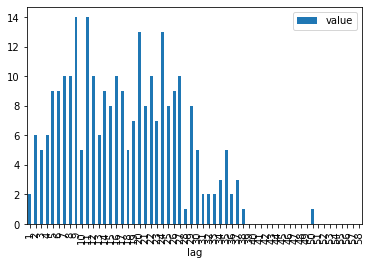

In [40]:
pd.read_sql("SELECT value, lag FROM nhs_totals_trust WHERE Name='WEST HERTFORDSHIRE HOSPITALS NHS TRUST'", DB.conn).groupby(['lag']).sum().plot(kind='bar')

## Public Health England

Data published by Public Health England:
    
- [Cases](https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv)
- [Deaths](https://coronavirus.data.gov.uk/downloads/csv/coronavirus-deaths_latest.csv)

In [75]:
#via https://stackoverflow.com/questions/61415090/python-pandas-handling-of-308-request
import requests
import io

def get_308_csv(url):
    datastr = requests.get(url, allow_redirects=True).text
    data_file = io.StringIO(datastr)
    _df = pd.read_csv(data_file)
    _df['Specimen date'] =  pd.to_datetime(_df['Specimen date'])
    return _df

In [76]:
phe_cases_url = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-cases_latest.csv'
phe_cases_df = get_308_csv(phe_cases_url)

_table = f'phe_cases'
phe_cases_df.to_sql(_table, DB.conn, index=False, if_exists='append')
    
phe_cases_df.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-08,63.0,0.0,63.0,134975,133626.0,1349.0
1,South West,E12000009,Region,2020-05-08,9.0,NaN,NaN,6974,NaN,NaN
2,South East,E12000008,Region,2020-05-08,5.0,NaN,NaN,19119,NaN,NaN
3,London,E12000007,Region,2020-05-08,0.0,NaN,NaN,25734,NaN,NaN
4,East of England,E12000006,Region,2020-05-08,1.0,NaN,NaN,12076,NaN,NaN


In [77]:
pd.read_sql("SELECT * FROM phe_cases LIMIT 3", DB.conn)

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-08 00:00:00,63.0,0.0,63.0,134975,133626.0,1349.0
1,South West,E12000009,Region,2020-05-08 00:00:00,9.0,NaN,NaN,6974,NaN,NaN
2,South East,E12000008,Region,2020-05-08 00:00:00,5.0,NaN,NaN,19119,NaN,NaN


In [78]:
phe_deaths_url = 'https://coronavirus.data.gov.uk/downloads/csv/coronavirus-deaths_latest.csv'
phe_deaths_df = get_308_csv(phe_cases_url)

_table = f'phe_deaths'
phe_cases_df.to_sql(_table, DB.conn, index=False, if_exists='append')

phe_deaths_df.head()

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-08,63.0,0.0,63.0,134975,133626.0,1349.0
1,South West,E12000009,Region,2020-05-08,9.0,NaN,NaN,6974,NaN,NaN
2,South East,E12000008,Region,2020-05-08,5.0,NaN,NaN,19119,NaN,NaN
3,London,E12000007,Region,2020-05-08,0.0,NaN,NaN,25734,NaN,NaN
4,East of England,E12000006,Region,2020-05-08,1.0,NaN,NaN,12076,NaN,NaN


In [79]:
pd.read_sql("SELECT * FROM phe_deaths LIMIT 3", DB.conn)

,Area name,Area code,Area type,Specimen date,Daily lab-confirmed cases,Previously reported daily cases,Change in daily cases,Cumulative lab-confirmed cases,Previously reported cumulative cases,Change in cumulative cases
0,England,E92000001,Nation,2020-05-08 00:00:00,63.0,0.0,63.0,134975,133626.0,1349.0
1,South West,E12000009,Region,2020-05-08 00:00:00,9.0,NaN,NaN,6974,NaN,NaN
2,South East,E12000008,Region,2020-05-08 00:00:00,5.0,NaN,NaN,19119,NaN,NaN


### NHS - A&E

Monthly data:
https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/ae-attendances-and-emergency-admissions-2019-20/

Hospital Episode Statistics:
https://digital.nhs.uk/data-and-information/publications/statistical/hospital-episode-statistics-for-admitted-patient-care-outpatient-and-accident-and-emergency-data

## ONS

Death registrations, 2020: https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard

Weekly Death registrations (provisional):
https://www.ons.gov.uk/peoplepopulationandcommunity/birthsdeathsandmarriages/deaths/datasets/weeklyprovisionalfiguresondeathsregisteredinenglandandwales


### Weekly deaths, ONS:

In [80]:
ons_weekly_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fbirthsdeathsandmarriages%2fdeaths%2fdatasets%2fweeklyprovisionalfiguresondeathsregisteredinenglandandwales%2f2020/publishedweek1620201.xlsx'


In [81]:
r = requests.get(ons_weekly_url)

fn = ons_weekly_url.split('/')[-1]
 
with open(fn, 'wb') as f:
    f.write(r.content)

ons_sheets = pd.read_excel(fn, sheet_name=None)

# What sheets are available in the spreadsheet
ons_sheet_names = ons_sheets.keys()
ons_sheet_names

odict_keys(['Analysis', 'Contents', 'Information', 'Terms and conditions', 'Weekly figures 2020', 'Covid-19 - Weekly registrations', 'Covid-19 - Weekly occurrences', 'UK - Covid-19 - Weekly reg', 'Covid-19 - E&W comparisons', 'Covid-19 - England comparisons', 'Covid-19 - Wales comparison', 'Covid-19 - Place of occurrence ', 'Related publications'])

In [82]:
ons_weekly_reg = ons_sheets['Covid-19 - Weekly registrations']
ons_weekly_reg.head()

,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,Weekly provisional figures on deaths registere...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Note that up-to-date counts of the total numbe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Week number,NaN,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
4,Week ended,NaN,2020-01-03 00:00:00,2020-01-10 00:00:00,2020-01-17 00:00:00,2020-01-24 00:00:00,2020-01-31 00:00:00,2020-02-07 00:00:00,2020-02-14 00:00:00,2020-02-21 00:00:00,...,2020-10-30 00:00:00,2020-11-06 00:00:00,2020-11-13 00:00:00,2020-11-20 00:00:00,2020-11-27 00:00:00,2020-12-04 00:00:00,2020-12-11 00:00:00,2020-12-18 00:00:00,2020-12-25 00:00:00,2021-01-01 00:00:00


In [83]:
ons_weekly_occ = ons_sheets['Covid-19 - Weekly occurrences']
ons_weekly_occ.head()

,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54,Unnamed: 55
0,Weekly provisional figures on death occurrence...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Note that up-to-date counts of the total numbe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Week number,NaN,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
4,Week ended,NaN,2020-01-03 00:00:00,2020-01-10 00:00:00,2020-01-17 00:00:00,2020-01-24 00:00:00,2020-01-31 00:00:00,2020-02-07 00:00:00,2020-02-14 00:00:00,2020-02-21 00:00:00,...,2020-10-30 00:00:00,2020-11-06 00:00:00,2020-11-13 00:00:00,2020-11-20 00:00:00,2020-11-27 00:00:00,2020-12-04 00:00:00,2020-12-11 00:00:00,2020-12-18 00:00:00,2020-12-25 00:00:00,2021-01-01 00:00:00


In [84]:
def ons_weeklies(ons_weekly, typ):
    ons_weekly_long = {}
    rows, cols = np.where(ons_weekly == 'Week ended')
    colnames = ons_weekly.iloc[rows[0]].tolist()
    colnames[1] = 'Age'

    rows, cols = np.where(ons_weekly == 'Deaths by age group')
    _rows, _ = np.where(ons_weekly == '90+')
    _ix = rows[0]

    tables = []


    #Get the first three tables - for Persons, Males and Females
    for r, c in zip(rows, cols):
        tables.append(ons_weekly.iloc[r-1, c].split()[0])

    for r, _r, t in zip(rows, _rows, tables):
        ons_weekly_long[t] = ons_weekly.iloc[r+1: _r+1]
        ons_weekly_long[t].columns = colnames
        ons_weekly_long[t].dropna(axis=1, how='all', inplace=True)
        if 'Year to date' in ons_weekly_long[t].columns:
            ons_weekly_long[t].drop(columns=['Year to date'], inplace=True)
        ons_weekly_long[t] = ons_weekly_long[t].melt(id_vars=['Age'], var_name='Date', value_name='value')
        ons_weekly_long[t]['measure'] = typ
        ons_weekly_long[t]['Date'] = pd.to_datetime(ons_weekly_long[t]['Date'])

    ons_weekly_long['Any'] = pd.DataFrame()
    for t in tables:
        ons_weekly_long[t]['Group'] = t
        ons_weekly_long['Any'] = pd.concat([ons_weekly_long['Any'], ons_weekly_long[t]])
    
    ons_weekly_long['Any'].reset_index(inplace=True, drop=True)
    
    return ons_weekly_long

In [85]:
ons_weekly_reg_long = ons_weeklies(ons_weekly_reg, 'Weekly registrations')
ons_weekly_reg_long['Females']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Age,Date,value,measure,Group
0,<1,2020-01-03,0,Weekly registrations,Females
1,1-4,2020-01-03,0,Weekly registrations,Females
2,5-9,2020-01-03,0,Weekly registrations,Females
3,10-14,2020-01-03,0,Weekly registrations,Females
4,15-19,2020-01-03,0,Weekly registrations,Females
...,...,...,...,...,...
315,70-74,2020-04-17,298,Weekly registrations,Females
316,75-79,2020-04-17,465,Weekly registrations,Females
317,80-84,2020-04-17,652,Weekly registrations,Females
318,85-89,2020-04-17,781,Weekly registrations,Females


In [86]:
ons_weekly_reg_long['Any']

,Age,Date,value,measure,Group
0,<1,2020-01-03,0,Weekly registrations,Persons
1,1-4,2020-01-03,0,Weekly registrations,Persons
2,5-9,2020-01-03,0,Weekly registrations,Persons
3,10-14,2020-01-03,0,Weekly registrations,Persons
4,15-19,2020-01-03,0,Weekly registrations,Persons
...,...,...,...,...,...
955,70-74,2020-04-17,298,Weekly registrations,Females
956,75-79,2020-04-17,465,Weekly registrations,Females
957,80-84,2020-04-17,652,Weekly registrations,Females
958,85-89,2020-04-17,781,Weekly registrations,Females


In [87]:
ons_weekly_occ_long = ons_weeklies(ons_weekly_occ, 'Weekly occurrences')
ons_weekly_occ_long['Males']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,Age,Date,value,measure,Group
0,<1,2020-01-03,0,Weekly occurrences,Males
1,1-4,2020-01-03,0,Weekly occurrences,Males
2,5-9,2020-01-03,0,Weekly occurrences,Males
3,10-14,2020-01-03,0,Weekly occurrences,Males
4,15-19,2020-01-03,0,Weekly occurrences,Males
...,...,...,...,...,...
315,70-74,2020-04-17,459,Weekly occurrences,Males
316,75-79,2020-04-17,597,Weekly occurrences,Males
317,80-84,2020-04-17,803,Weekly occurrences,Males
318,85-89,2020-04-17,793,Weekly occurrences,Males


In [88]:
ons_weekly_all = ons_sheets['Weekly figures 2020']
ons_weekly_all.head()

,Contents,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,...,Unnamed: 45,Unnamed: 46,Unnamed: 47,Unnamed: 48,Unnamed: 49,Unnamed: 50,Unnamed: 51,Unnamed: 52,Unnamed: 53,Unnamed: 54
0,Weekly provisional figures on deaths registere...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,Note that up-to-date counts of the total numbe...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,Week number,NaN,1,2,3,4,5,6,7,8,...,44,45,46,47,48,49,50,51,52,53
4,Week ended,NaN,2020-01-03 00:00:00,2020-01-10 00:00:00,2020-01-17 00:00:00,2020-01-24 00:00:00,2020-01-31 00:00:00,2020-02-07 00:00:00,2020-02-14 00:00:00,2020-02-21 00:00:00,...,2020-10-30 00:00:00,2020-11-06 00:00:00,2020-11-13 00:00:00,2020-11-20 00:00:00,2020-11-27 00:00:00,2020-12-04 00:00:00,2020-12-11 00:00:00,2020-12-18 00:00:00,2020-12-25 00:00:00,2021-01-01 00:00:00


In [89]:
ons_weekly_all_long = ons_weeklies(ons_weekly_all, 'Weekly all mortality')
ons_weekly_all_long['Males']

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,Age,Date,value,measure,Group
0,<1,2020-01-03,30,Weekly all mortality,Males
1,1-4,2020-01-03,5,Weekly all mortality,Males
2,5-9,2020-01-03,2,Weekly all mortality,Males
3,10-14,2020-01-03,1,Weekly all mortality,Males
4,15-19,2020-01-03,5,Weekly all mortality,Males
...,...,...,...,...,...
315,70-74,2020-04-17,1280,Weekly all mortality,Males
316,75-79,2020-04-17,1635,Weekly all mortality,Males
317,80-84,2020-04-17,2100,Weekly all mortality,Males
318,85-89,2020-04-17,2111,Weekly all mortality,Males


Add to database...

In [90]:
_table = 'ons_deaths'

ons_weekly_occ_long['Any'].to_sql(_table, DB.conn, index=False, if_exists='append')
ons_weekly_reg_long['Any'].to_sql(_table, DB.conn, index=False, if_exists='append')
ons_weekly_all_long['Any'].to_sql(_table, DB.conn, index=False, if_exists='append')

### ONS Death Registrations, 2020

https://www.ons.gov.uk/peoplepopulationandcommunity/healthandsocialcare/causesofdeath/datasets/deathregistrationsandoccurrencesbylocalauthorityandhealthboard

In [91]:
ons_death_reg_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fhealthandsocialcare%2fcausesofdeath%2fdatasets%2fdeathregistrationsandoccurrencesbylocalauthorityandhealthboard%2f2020/lahbtablesweek16.xlsx'

In [92]:
r = requests.get(ons_death_reg_url)

fn = ons_death_reg_url.split('/')[-1]
 
with open(fn, 'wb') as f:
    f.write(r.content)

ons_reg_sheets = pd.read_excel(fn, sheet_name=None)

# What sheets are available in the spreadsheet
ons_reg_sheet_names = ons_reg_sheets.keys()
ons_reg_sheet_names

odict_keys(['Contents', 'Information', 'Terms and conditions', 'Registrations - All data', 'Registrations - Pivot table', 'Occurrences - All data', 'Occurrences - Pivot table'])

In [93]:
ons_death_reg = ons_reg_sheets['Registrations - All data']
ons_death_reg_metadata = ons_death_reg.iloc[0, 0]
ons_death_reg_metadata

'Deaths (numbers) by local authority and cause of death, registered up to the 17th April 2020, England and Wales'

In [94]:
from parse import parse
import dateparser

upto = parse('Deaths (numbers) by local authority and cause of death, registered up to the {date}, England and Wales',
             ons_death_reg_metadata)['date']
upto = dateparser.parse(upto)

rows, cols = np.where(ons_death_reg == 'Area code')
colnames = ons_death_reg.iloc[rows[0]].tolist()
    
ons_death_reg = ons_death_reg.iloc[rows[0]+1:].reset_index(drop=True)
ons_death_reg.columns = colnames


ons_death_reg['Registered up to'] = upto
ons_death_reg

,Area code,Geography type,Area name,Cause of death,Week number,Place of death,Number of deaths,Registered up to
0,E06000001,Local Authority,Hartlepool,All causes,1,Care home,8,2020-04-17
1,E06000001,Local Authority,Hartlepool,COVID 19,1,Care home,0,2020-04-17
2,E06000001,Local Authority,Hartlepool,All causes,1,Elsewhere,0,2020-04-17
3,E06000001,Local Authority,Hartlepool,COVID 19,1,Elsewhere,0,2020-04-17
4,E06000001,Local Authority,Hartlepool,All causes,1,Home,2,2020-04-17
...,...,...,...,...,...,...,...,...
64766,W11000030,Health Board,Cwm Taf Morgannwg University Health Board,COVID 19,16,Home,4,2020-04-17
64767,W11000030,Health Board,Cwm Taf Morgannwg University Health Board,COVID 19,16,Hospital,53,2020-04-17
64768,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Care home,6,2020-04-17
64769,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Hospital,47,2020-04-17


In [95]:
ons_death_occ = ons_reg_sheets['Occurrences - All data']
ons_death_occ_metadata = ons_death_occ.iloc[0, 0]
ons_death_occ_metadata

uptos = parse('Deaths (numbers) by local authority and cause of death, for deaths that occurred up to {date_occ} but were registered up to the {date_reg}, England and Wales',
             ons_death_occ_metadata)

upto_occ = uptos['date_occ']
if '2020' not in upto_occ: upto_occ = f'{upto_occ} 2020'
    
upto_reg = uptos['date_reg']
if '2020' not in upto_occ: upto_occ = f'{upto_reg} 2020'

upto_occ = dateparser.parse(upto_occ)
upto_reg = dateparser.parse(upto_reg)

rows, cols = np.where(ons_death_occ == 'Area code')
colnames = ons_death_occ.iloc[rows[0]].tolist()
    
ons_death_occ = ons_death_occ.iloc[rows[0]+1:].reset_index(drop=True)
ons_death_occ.columns = colnames


ons_death_occ['Occurred up to'] = upto_occ
ons_death_occ['Registered up to'] = upto_reg
ons_death_occ

,Area code,Geography type,Area name,Cause of death,Week number,Place of death,Number of deaths,Occurred up to,Registered up to
0,E06000001,Local Authority,Hartlepool,All causes,1,Care home,3,2020-04-17,2020-04-25
1,E06000001,Local Authority,Hartlepool,All causes,1,Elsewhere,0,2020-04-17,2020-04-25
2,E06000001,Local Authority,Hartlepool,All causes,1,Home,7,2020-04-17,2020-04-25
3,E06000001,Local Authority,Hartlepool,All causes,1,Hospice,1,2020-04-17,2020-04-25
4,E06000001,Local Authority,Hartlepool,All causes,1,Hospital,13,2020-04-17,2020-04-25
...,...,...,...,...,...,...,...,...,...
66427,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Elsewhere,0,2020-04-17,2020-04-25
66428,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Home,1,2020-04-17,2020-04-25
66429,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Hospice,0,2020-04-17,2020-04-25
66430,W11000031,Health Board,Swansea Bay University Health Board,COVID 19,16,Hospital,40,2020-04-17,2020-04-25


In [96]:
_table = 'ons_deaths_reg'
ons_death_reg.to_sql(_table, DB.conn, index=False, if_exists='append')

_table = 'ons_deaths_reg_occ'
ons_death_occ.to_sql(_table, DB.conn, index=False, if_exists='append')

## Deployment via datasette

`datasette publish fly nhs_dailies.db --app="nhs-orgs"`

## Simple Chat

In [65]:
# It takes tiny amounts of code to post s/thing from a notebook to an API and display a result


# Create some magic to call and API
from IPython.core.magic import register_cell_magic, register_line_magic
import requests
import pandas as pd

from urllib.parse import urlencode
    
_datasette_url = 'https://nhs-orgs.fly.dev/nhs_dailies/phe_cases.csv?{}'

@register_line_magic
def phe_cases(line):
    "Query datasette."
    payload = {'_sort': 'rowid',
               'Area name__contains': line,
               '_size': 'max'}
    _url =  _datasette_url.format(urlencode(payload))
    return pd.read_csv( _url)

In [ ]:
# Pass a string to the API via some magic and display the result

%phe_cases isle of wight

## Run as file

In [111]:
!python3 uk_daily_deaths_nhs.py

uk_daily_deaths_nhs.py:39: UserWarning: No parser was explicitly specified, so I'm using the best available HTML parser for this system ("lxml"). This usually isn't a problem, but if you run this code on another system, or in a different virtual environment, it may use a different parser and behave differently.

The code that caused this warning is on line 39 of the file uk_daily_deaths_nhs.py. To get rid of this warning, pass the additional argument 'features="lxml"' to the BeautifulSoup constructor.

  soup = BeautifulSoup(page.text)
COVID 19 daily announced deaths 9 May 2020
COVID19 daily deaths chart
COVID19 daily deaths by region
/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)
Deaths by region- no pos test 
COVID19 daily deaths by age
COVID19 daily deaths by trust
COVID 19 daily announced deaths 8 May 2020
COVID

## Looking Inside Downloaded Zip Files

In [ ]:
#https://techoverflow.net/2018/01/16/downloading-reading-a-zip-file-in-memory-using-python/
import zipfile

def download_extract_xml(url):
    """
    Download a ZIP file and extract its contents in memory
    yields (filename, file-like object) pairs
    """
    response = requests.get(url)
    with zipfile.ZipFile(io.BytesIO(response.content)) as thezip:
        for zipinfo in thezip.infolist():
            with thezip.open(zipinfo) as thefile:
                yield zipinfo.filename, thefile
                
r = download_extract_xml(ons_weekly_url)
for f in r:
    print(f)